<a href="https://colab.research.google.com/github/OmkarK-7/FindmeOut_/blob/main/Final_FaceReco_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules

In [159]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Lambda ,Dense ,Flatten , Dropout , GlobalAveragePooling2D

In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
print(os.listdir('/content/drive/MyDrive/A_face reco data/Training'))

['celeb1', 'celeb2', 'celeb3', 'celeb4']


# Processing the Data

In [162]:
X=[]
Z=[]
IMG_SIZE=64
celeb1_DIR='/content/drive/MyDrive/A_face reco data/Training/celeb1'
celeb2_DIR='/content/drive/MyDrive/A_face reco data/Training/celeb2'
celeb3_DIR='/content/drive/MyDrive/A_face reco data/Training/celeb3'
celeb4_DIR='/content/drive/MyDrive/A_face reco data/Training/celeb4'

In [163]:
def assign_label(img,person_name):
    return person_name

In [164]:
DIR = '/content/drive/MyDrive/A_face reco data/Training'

In [165]:
def make_train_data(person_name,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,person_name)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [166]:
make_train_data('Dwayne Johnson',celeb1_DIR)
print(len(X))

100%|██████████| 100/100 [00:00<00:00, 126.59it/s]

100


In [167]:
make_train_data('Elizabeth Olsen',celeb2_DIR)
print(len(X))

100%|██████████| 100/100 [00:00<00:00, 118.51it/s]

200


In [168]:
make_train_data('Johnny Depp',celeb3_DIR)
print(len(X))

100%|██████████| 100/100 [00:00<00:00, 174.46it/s]

300


In [169]:
make_train_data('Bill Gates',celeb4_DIR)
print(len(X))

100%|██████████| 100/100 [00:00<00:00, 180.10it/s]

400


Visualizing Random Photos from the dataset.

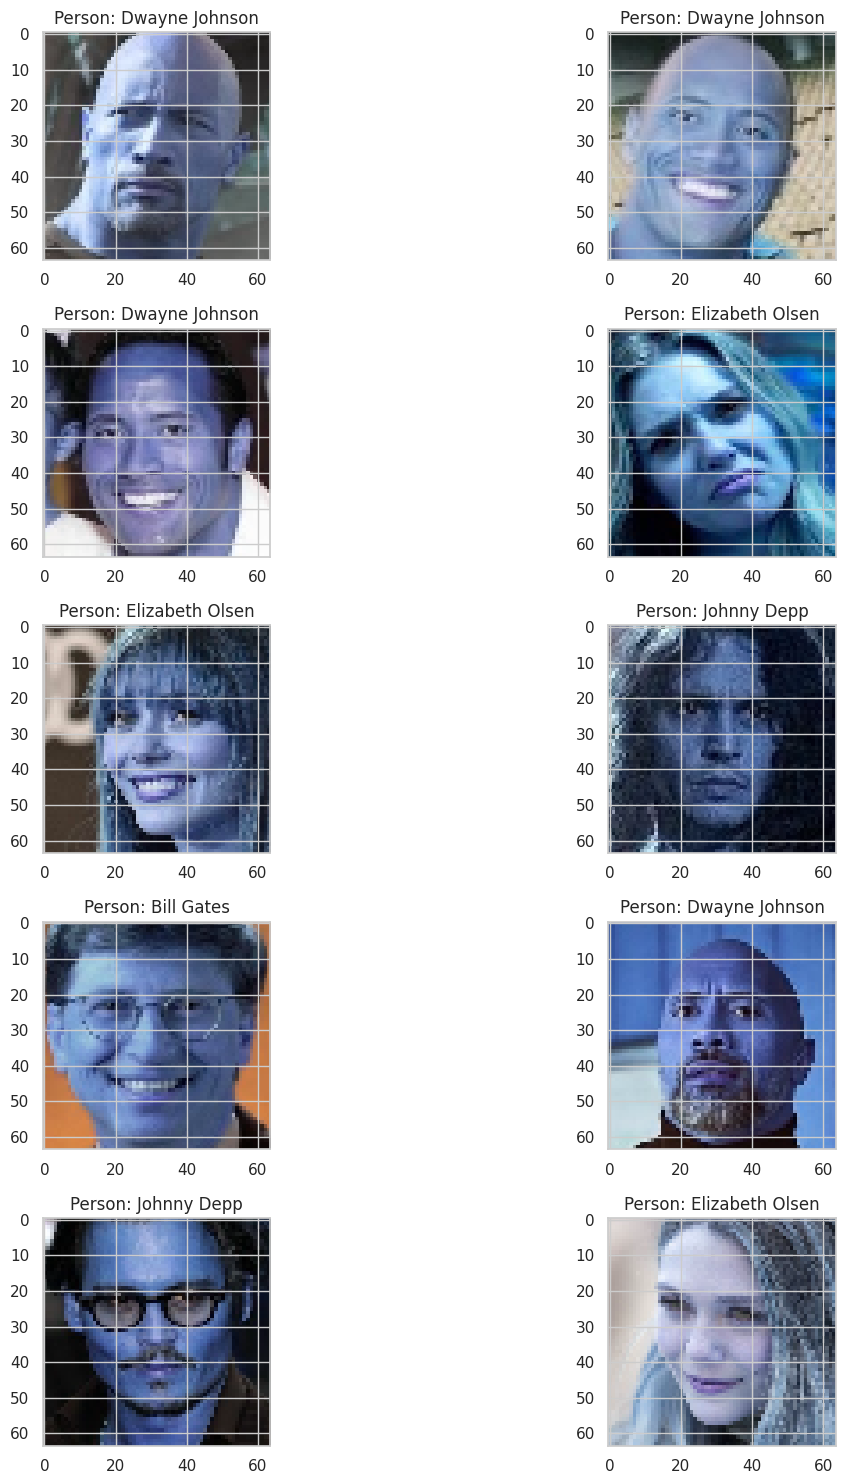

In [170]:
#Visualizing random Photos
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Person: '+Z[l])

plt.tight_layout()


Label Encoding followed by One Hot Encoding.

In [171]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,4)
X=np.array(X)
X=X/255

In [172]:
#Dividing the set in 75 and 25 training and test dataset
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [173]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# Specifying the Model

In [174]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(64,64,3))

In [175]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [176]:
#not train top layers
for layer in base_model.layers:
    layer.trainable = False


main_model = base_model.output
main_model = GlobalAveragePooling2D()(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(512,activation='relu')(main_model)
main_model = Dropout(0.5)(main_model)
main_model = Dense(4,activation='softmax')(main_model)

In [177]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [178]:
epochs=10
batch_size=64
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

In [179]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [180]:
# Create tf.data.Dataset objects for train_dataset and test_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle the training dataset (optional)
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))

# Batch the datasets and prefetch data for faster training
train_dataset = train_dataset.batch(15).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(15).prefetch(tf.data.AUTOTUNE)

In [181]:
#compiling
from keras.models import Model
model = Model(inputs = base_model.input , outputs = main_model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [182]:
History = model.fit_generator(train_dataset,
                              epochs=12,
                              validation_data=(test_dataset)
                              )

Epoch 1/12
20/20 [==============================] - 22s 1s/step - loss: 1.2495 - accuracy: 0.4433 - val_loss: 0.8434 - val_accuracy: 0.6900
Epoch 2/12
20/20 [==============================] - 21s 1s/step - loss: 0.6246 - accuracy: 0.7733 - val_loss: 0.4776 - val_accuracy: 0.8100
Epoch 3/12
20/20 [==============================] - 21s 1s/step - loss: 0.4393 - accuracy: 0.8433 - val_loss: 0.4350 - val_accuracy: 0.8700
Epoch 4/12
20/20 [==============================] - 21s 1s/step - loss: 0.2707 - accuracy: 0.9100 - val_loss: 0.5665 - val_accuracy: 0.8300
Epoch 5/12
20/20 [==============================] - 21s 1s/step - loss: 0.2561 - accuracy: 0.9133 - val_loss: 0.3697 - val_accuracy: 0.8600
Epoch 6/12
20/20 [==============================] - 26s 1s/step - loss: 0.1334 - accuracy: 0.9500 - val_loss: 0.6594 - val_accuracy: 0.8400
Epoch 7/12
20/20 [==============================] - 26s 1s/step - loss: 0.1531 - accuracy: 0.9400 - val_loss: 0.3243 - val_accuracy: 0.9000
Epoch 8/12
20/20 [==

# Graphs and Outputs

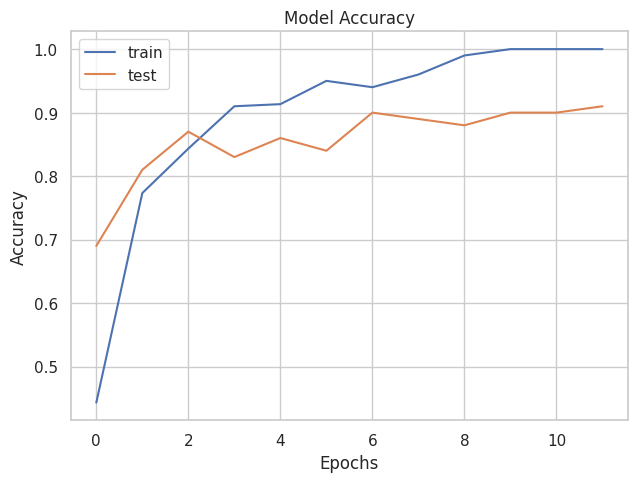

In [183]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

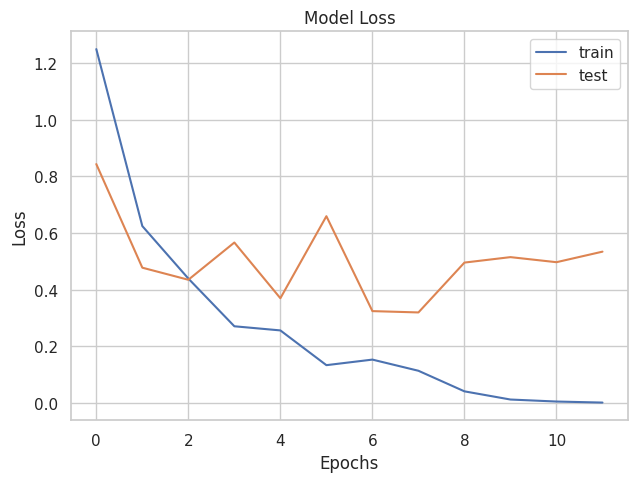

In [184]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [185]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

4/4 [==============================] - 7s 977ms/step


In [186]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

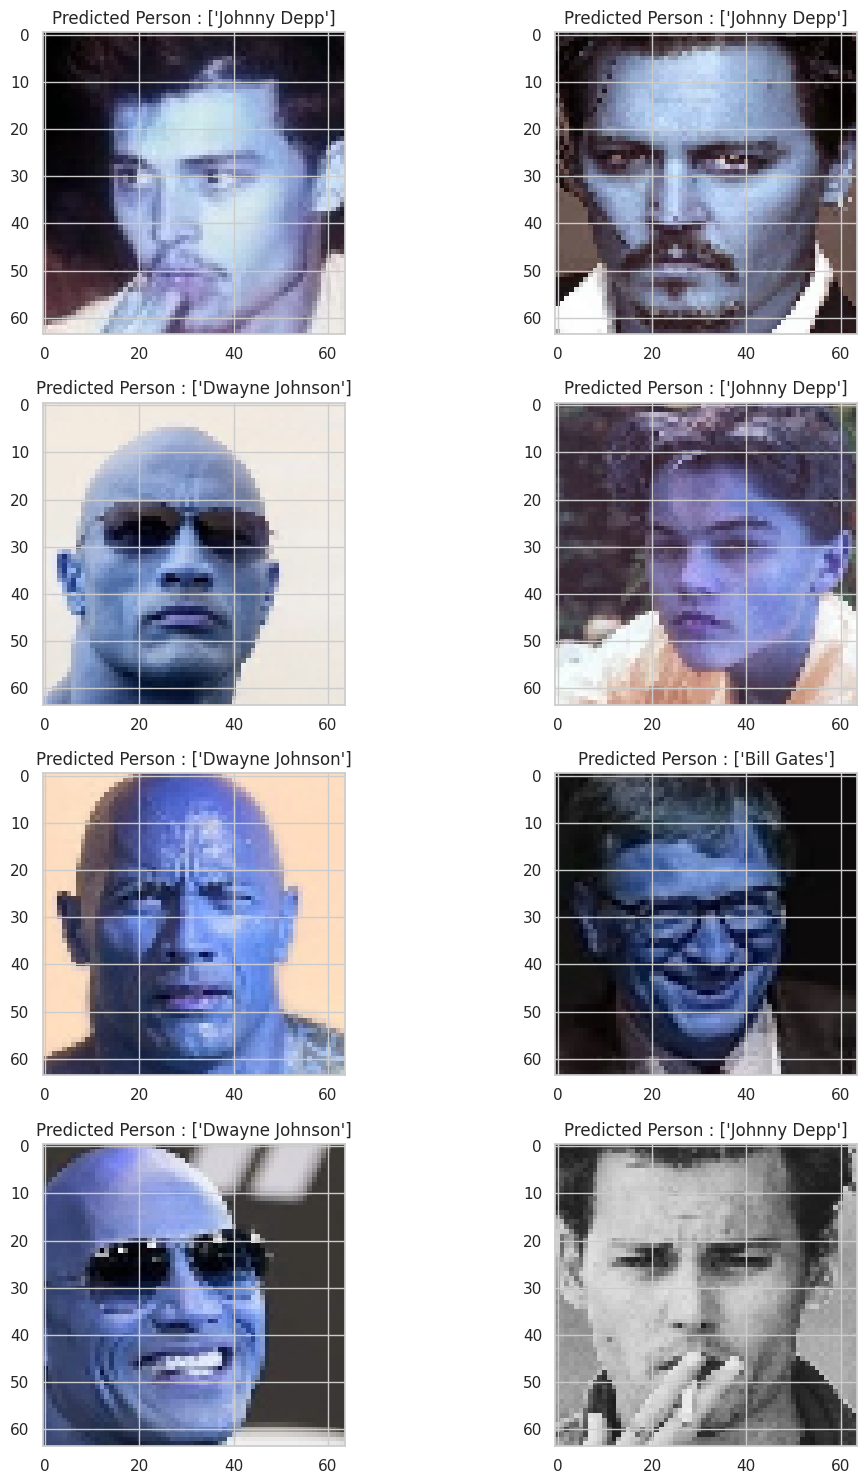

In [187]:
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Person : "+str(le.inverse_transform([pred_digits[prop_class[count]]])))
        plt.tight_layout()
        count+=1

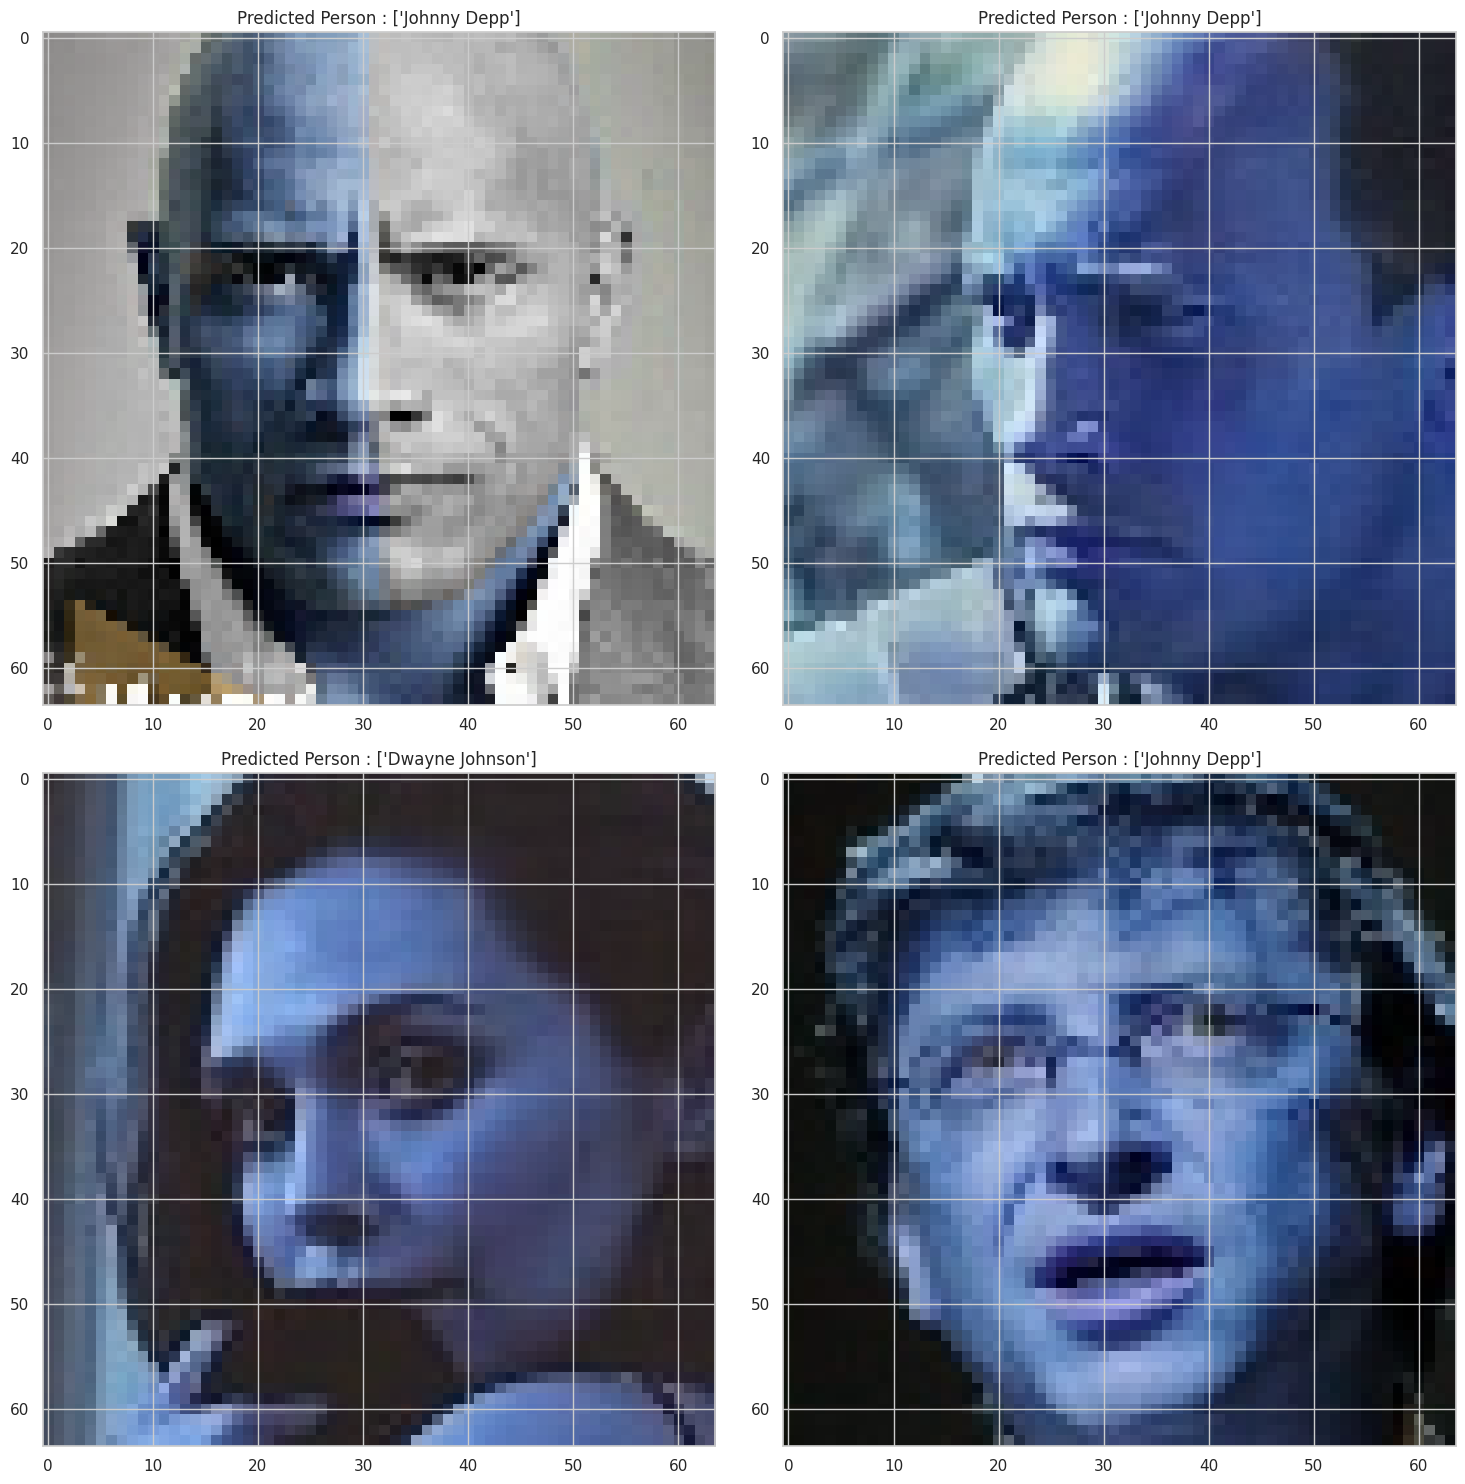

In [190]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(2,2)
fig.set_size_inches(15,15)
for i in range (2):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Person : "+str(le.inverse_transform([pred_digits[prop_class[count]]])))
        plt.tight_layout()
        count+=1